<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-моделей-для-каждого-региона" data-toc-modified-id="Обучение-и-проверка-моделей-для-каждого-региона-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка моделей для каждого региона</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Создание-фунции-для-расчёта-прибыли-по-выбранным-скважинам-и-предсказаниям-модели" data-toc-modified-id="Создание-фунции-для-расчёта-прибыли-по-выбранным-скважинам-и-предсказаниям-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Создание фунции для расчёта прибыли по выбранным скважинам и предсказаниям модели</a></span></li><li><span><a href="#Расчёт-рисков-и-прибыли-для-каждого-региона" data-toc-modified-id="Расчёт-рисков-и-прибыли-для-каждого-региона-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Расчёт рисков и прибыли для каждого региона</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Проект: выбор локации для нефтяной скважины

Описание проекта: для добывающей компании «ГлавРосГосНефть» необходимо построить модель для определения региона, где добыча нефти принесёт наибольшую прибыль. Проанализировать прибыль и риски техникой Bootstrap.
Шаги для выбора локации следующие:
- в избранном регионе собирают характеристики для скважин - качество нефти и объём её запасов;
- строят модель для предсказания объёма запасов в новых скважинах;
- выбирают скважины с самыми высокими оценками значений;
- определяют регион с максимальной суммарной прибылью отобранных скважин.

Нам предоставлены пробы нефти в трёх регионах, характеристики для каждой скважины в регионе уже известны.

## Загрузка и подготовка данных

In [1]:
! pip install matplotlib==3.7.1 -q
! pip install -U scikit-learn -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 2.0.2 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.24.4 which is incompatible.


Загрузим необходимые библиотеки:

In [2]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

from scipy import stats as st

import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Загрузим датасеты и сохраним их в одноимённые переменные:

In [4]:
try:
    # Данные геологоразведки 0
    geo_data_0 = pd.read_csv('geo_data_0.csv')
    # Данные геологоразведки 1
    geo_data_1 = pd.read_csv('geo_data_1.csv')
    # Данные геологоразведки 2
    geo_data_2 = pd.read_csv('geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Проверим, что данные загрузились корректно:

In [5]:
# функция для получения информации о датасете
def get_info(dataset):
    print('Первые пять строк датасета:')
    display(dataset.head())
    print('Общая информация:')
    dataset.info()

In [6]:
get_info(geo_data_0)

Первые пять строк датасета:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
get_info(geo_data_1)

Первые пять строк датасета:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
get_info(geo_data_2)

Первые пять строк датасета:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Названия столбцов не требуют приведения к единому виду (snake_case, латиница, строчные буквы), а типы данных в столбцах соответствуют значениям.

Датасеты содержат следующие данные:

- `id` - уникальный идентификатор скважины;
- `f0`, `f1`, `f2` - три значимых признака точек;
- `product` - объём запасов в скважине, тыс. баррелей

Для решения задачи нам даны условия:
1. Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
2. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
3. Бюджет на разработку скважин в регионе — 10 млрд. руб.
4. При нынешних ценах один баррель сырья приносит 450 руб. дохода. Доход с каждой единицы продукта составляет 450 тыс. руб., поскольку объём указан в тысячах баррелей.
5. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

### Предобработка данных

Проверим датасеты на пропущенные значения и дубликаты:

In [9]:
geo_data_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [10]:
geo_data_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [11]:
geo_data_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Пропущенные значения и неявные дубликаты отсутствуют

In [12]:
geo_data_0.duplicated().sum()

0

In [13]:
geo_data_1.duplicated().sum()

0

In [14]:
geo_data_2.duplicated().sum()

0

Явные дубликаты также отсутствуют

### Исследовательский анализ данных

Проведём статистический анализ количественных признаков каждого датасета:

In [15]:
geo_data_0.describe().round(2)

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


In [16]:
geo_data_1.describe().round(2)

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


In [17]:
geo_data_2.describe().round(2)

,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


Из-за отсутствия подробностей о признаках `f0`, `f1`, `f2` сложно однозначно сказать, имеются ли в них подозрительные данные. Тем не менее, каких-то аномальных значений не наблюдается ни в одном из признаков.

Посмотрим на долю выбросов в каждом столбце датасетов:

In [18]:
def outliers(dataset, column):
    q1 = dataset[column].quantile(0.25) # первый квартиль
    q3 = dataset[column].quantile(0.75)  # третий квартиль
    iqr = q3 - q1  # межквартильный размах
    quant1 = q1 - 1.5*iqr  # нижняя граница выбросов
    quant3 = q3 + 1.5*iqr  # верхняя граница выбросов
    total = dataset.shape[0]  # общее количество строк в датафрейме
    emission = dataset[(dataset[column] < quant1) | \
     (dataset[column] > quant3)].shape[0]
    # количество выбросов
    emission_quant = (emission / total) * 100  # доля выбросов в столбце
    return np.round((emission_quant), decimals=2)
    # возвращаем долю выбросов в столбце

# Столбцы с выбросами
dataset = geo_data_0
column_list = ['f0', 'f1', 'f2', 'product']  # список столбцов с выбросами
for value in column_list:  # цикл по столбцам с выбросами
    print(f'Доля выбросов в {value} в процентах: {outliers(dataset, value)}')

dataset = geo_data_1
column_list = ['f0', 'f1', 'f2', 'product']
for value in column_list:
    print(f'Доля выбросов в {value} в процентах: {outliers(dataset, value)}')

dataset = geo_data_2
column_list = ['f0', 'f1', 'f2', 'product']
for value in column_list:
    print(f'Доля выбросов в {value} в процентах: {outliers(dataset, value)}')

Доля выбросов в f0 в процентах: 0.0
Доля выбросов в f1 в процентах: 0.0
Доля выбросов в f2 в процентах: 0.51
Доля выбросов в product в процентах: 0.0
Доля выбросов в f0 в процентах: 0.0
Доля выбросов в f1 в процентах: 0.64
Доля выбросов в f2 в процентах: 0.0
Доля выбросов в product в процентах: 0.0
Доля выбросов в f0 в процентах: 0.73
Доля выбросов в f1 в процентах: 0.68
Доля выбросов в f2 в процентах: 0.58
Доля выбросов в product в процентах: 0.0


Выбросы в данных имеются, но их доли незначительны, можно пренебречь. Построим гистограммы распределения признаков:

In [19]:
# Гистограмма распределения количественных признаков
def histogram(dataset, column):
    dataset[column].plot(kind='hist', bins=20, grid=True, \
                figsize=(5, 5), title=(f'Распределение признака "{column}"'))
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.show()
    return None

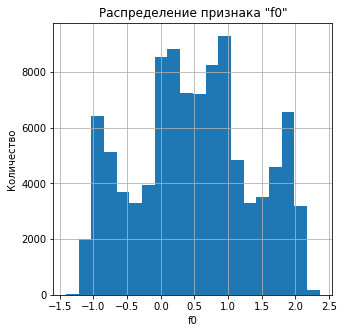

In [20]:
histogram(geo_data_0, 'f0')

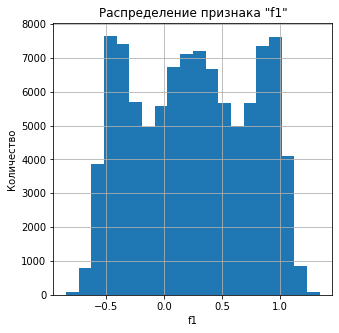

In [21]:
histogram(geo_data_0, 'f1')

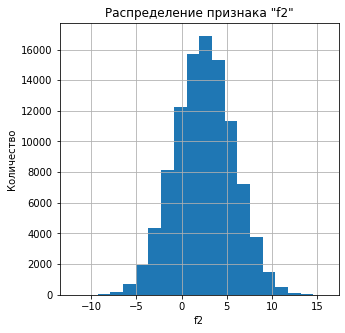

In [22]:
histogram(geo_data_0, 'f2')

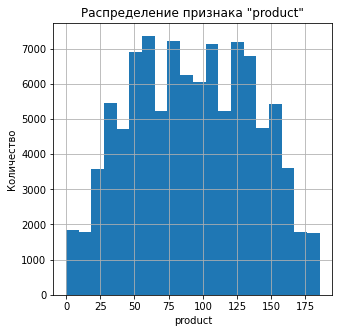

In [23]:
histogram(geo_data_0, 'product')

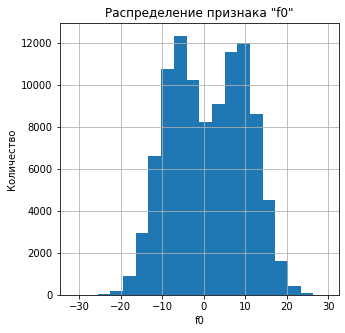

In [24]:
histogram(geo_data_1, 'f0')

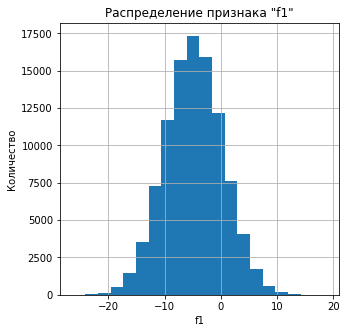

In [25]:
histogram(geo_data_1, 'f1')

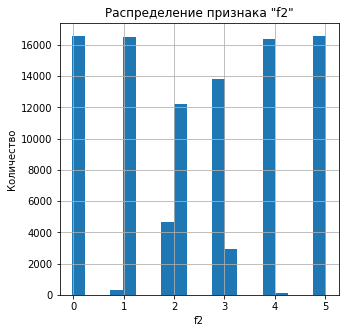

In [26]:
histogram(geo_data_1, 'f2')

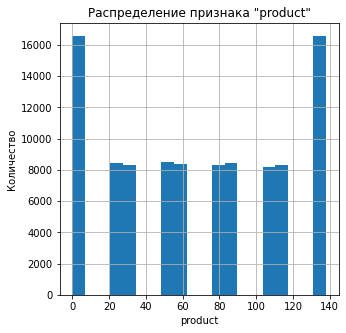

In [27]:
histogram(geo_data_1, 'product')

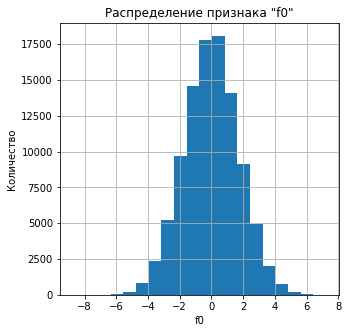

In [28]:
histogram(geo_data_2, 'f0')

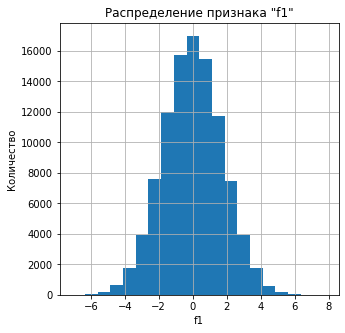

In [29]:
histogram(geo_data_2, 'f1')

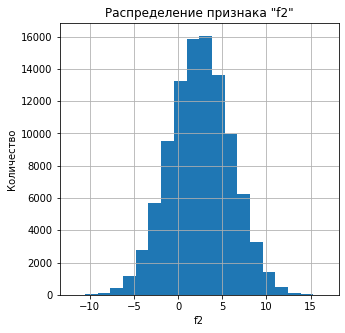

In [30]:
histogram(geo_data_2, 'f2')

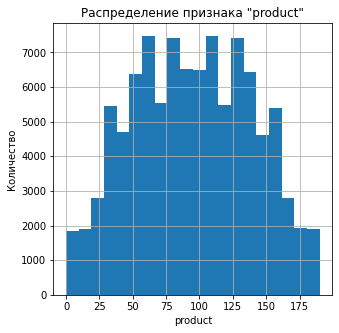

In [31]:
histogram(geo_data_2, 'product')

Все распределения нормальные, за исключением признаков `f2` и `product` датасета `geo_data_1`

Проведём корреляционный анализ признаков датасетов. Будем использовать коэффициент корреляции Пирсона, т.к. категориальные признаки отсутствуют, а распределения в основном нормальные:

<Axes: >

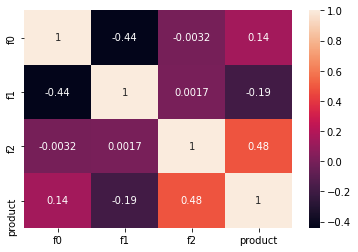

In [32]:
sns.heatmap(geo_data_0.drop(['id'], axis=1).corr(), annot=True)

<Axes: >

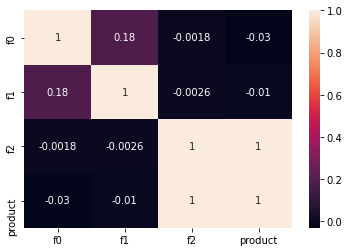

In [33]:
sns.heatmap(geo_data_1.drop(['id'], axis=1).corr(), annot=True)

<Axes: >

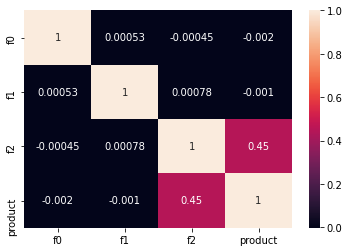

In [34]:
sns.heatmap(geo_data_2.drop(['id'], axis=1).corr(), annot=True)

Согласно шкале Чеддока, наблюдается умеренная связь между признаками `f2` и `product` в датасетах `geo_data_0` `geo_data_2` (0.48 и 0.45, соответственно) и весьма высокая связь между этими же признаками в датасете `geo_data_1` (1)

Выводы по разделу:

- загрузили и изучили данные из трёх предоставленных датасетов;
- пропуски, явные и неявные дубликаты в данных не обнаружены;
- провели исследовательский анализ данных, все распределения данных в признаках нормальные, за исключением `f2` и `product` датасета `geo_data_1`;
- провели корреляционный анализ данных, который показал наличие умеренной связи между признаками `f2` и `product` в датасетах `geo_data_0` `geo_data_2` и весьма высокой связи между этими же признаками в датасете `geo_data_1`.

## Обучение и проверка моделей для каждого региона

Удалим столбец `id` из датасетов, т.к. он мешает обучению моделей:

In [35]:
geo_data_0 = geo_data_0.drop(['id'], axis=1)
geo_data_1 = geo_data_1.drop(['id'], axis=1)
geo_data_2 = geo_data_2.drop(['id'], axis=1)

Посчитаем значения среднего запаса предсказанного сырья и RMSE моделей для каждого региона:

In [36]:
geo_data_0_train, geo_data_0_valid = train_test_split(geo_data_0, \
                          test_size=TEST_SIZE, random_state=RANDOM_STATE)
features_train_0 = geo_data_0_train.drop(['product'], axis=1)
target_train_0 = geo_data_0_train['product']
features_valid_0 = geo_data_0_valid.drop(['product'], axis=1)
target_valid_0 = geo_data_0_valid['product']

model = LinearRegression()
model.fit(features_train_0, target_train_0)
pred_valid_0 = pd.Series(model.predict(features_valid_0))
rmse = mean_squared_error(target_valid_0, pred_valid_0) ** 0.5
print('Средний запас предсказанного сырья в регионе 0:', \
      pred_valid_0.mean().round(2),\
      'тыс. баррелей, значение RMSE:', rmse.round(2))

Средний запас предсказанного сырья в регионе 0: 92.4 тыс. баррелей, значение RMSE: 37.76


In [37]:
geo_data_1_train, geo_data_1_valid = train_test_split(geo_data_1, \
                          test_size=TEST_SIZE, random_state=RANDOM_STATE)
features_train_1 = geo_data_1_train.drop(['product'], axis=1)
target_train_1 = geo_data_1_train['product']
features_valid_1 = geo_data_1_valid.drop(['product'], axis=1)
target_valid_1 = geo_data_1_valid['product']

model = LinearRegression()
model.fit(features_train_1, target_train_1)
pred_valid_1 = pd.Series(model.predict(features_valid_1))
rmse = mean_squared_error(target_valid_1, pred_valid_1) ** 0.5
print('Средний запас предсказанного сырья в регионе 1:', \
      pred_valid_1.mean().round(2),\
      'тыс. баррелей, значение RMSE:', rmse.round(2))

Средний запас предсказанного сырья в регионе 1: 68.71 тыс. баррелей, значение RMSE: 0.89


In [38]:
geo_data_2_train, geo_data_2_valid = train_test_split(geo_data_2, \
                          test_size=TEST_SIZE, random_state=RANDOM_STATE)
features_train_2 = geo_data_2_train.drop(['product'], axis=1)
target_train_2 = geo_data_2_train['product']
features_valid_2 = geo_data_2_valid.drop(['product'], axis=1)
target_valid_2 = geo_data_2_valid['product']

model = LinearRegression()
model.fit(features_train_2, target_train_2)
pred_valid_2 = pd.Series(model.predict(features_valid_2))
rmse = mean_squared_error(target_valid_2, pred_valid_2) ** 0.5
print('Средний запас предсказанного сырья в регионе 2:', \
      pred_valid_2.mean().round(2),\
      'тыс. баррелей, значение RMSE:', rmse.round(2))

Средний запас предсказанного сырья в регионе 2: 94.77 тыс. баррелей, значение RMSE: 40.15


Реальные средние запасы по каждому региону при этом:

In [39]:
target_valid_0.mean().round(2)

92.33

In [40]:
target_valid_1.mean().round(2)

68.73

In [41]:
target_valid_2.mean().round(2)

95.15

Выводы по разделу:

- обучили и проверили модели линейной регрессии для трёх исследуемых регионов;
- все три модели предсказывают значения запасов сырья, близкие к реальным. При этом самое низкое значение - в регионе 1 (68.7 тыс. баррелей);
- минимальное значение (0.89) среднеквадратичной ошибки - у модели для региона 1. Это можно объяснить наличием весьма высокой связи между признаком `f2` и целевым `product`.

## Подготовка к расчёту прибыли

Сохраним все ключевые значения для расчётов (см условия задачи в первом пункте Проекта) в отдельных переменных:

In [42]:
# количество исследуемых точек:
OIL_WELLS = 500
# количество лучших точек для разработки:
BEST_WELLS = 200
# бюджет на разработку скважин в регионе, в тыс. руб.:
BUDGET = 10_000_000
# доход с каждой единицы продукта, в тыс. руб.:
REVENUE_BY_ONE = 450
# порог вероятности убытков:
LOSSES = 0.025

Посчитаем достаточный объём сырья для безубыточной разработки новой скважины:

In [43]:
# затраты на разработку одной скважины:
WELLS_BUDGET = BUDGET / BEST_WELLS

# достаточный объём сырья для безубыточной разработки
WELLS_INCOME = WELLS_BUDGET / REVENUE_BY_ONE

print('Достаточный объём сырья для безубыточной разработки:', \
      round(WELLS_INCOME, 2), 'тыс. баррелей')

Достаточный объём сырья для безубыточной разработки: 111.11 тыс. баррелей


Вывод по разделу:

- согласно предоставленным условиям задачи, получили значение достаточного объёма сырья для безубыточной разработки скважины, равное 111.11 тыс. баррелей. Это больше, чем средние значения запаса сырья во всех трёх изучаемых регионах. Соответственно, велик риск не окупить затраченный на разработку скважин бюджет. Нужна модель для определения региона, в котором данный риск нивелируется, а добыча принесёт наибольшую прибыль.

## Создание фунции для расчёта прибыли по выбранным скважинам и предсказаниям модели

Для каждого региона выберем лучшие 200 скважин по значениям предсказанных ранее запасов. Создадим функцию для расчёта прибыли:

In [44]:
def profit_calc_function(target_valid, pred_valid):
    pred_sorted = pred_valid.sort_values(ascending=False).head(BEST_WELLS)
    target_sorted = target_valid.reset_index(drop=True)[pred_sorted.index]
    return ((REVENUE_BY_ONE * target_sorted.sum() - BUDGET) / 1000000).round(2)

In [45]:
print('Прибыль с 200 лучших скважин по региону 0 составляет: ', \
profit_calc_function(target_valid_0, pred_valid_0), ' млрд. руб.')

Прибыль с 200 лучших скважин по региону 0 составляет:  3.36  млрд. руб.


In [46]:
print('Прибыль с 200 лучших скважин по региону 1 составляет: ', \
profit_calc_function(target_valid_1, pred_valid_1), ' млрд. руб.')

Прибыль с 200 лучших скважин по региону 1 составляет:  2.42  млрд. руб.


In [47]:
print('Прибыль с 200 лучших скважин по региону 2 составляет: ', \
profit_calc_function(target_valid_2, pred_valid_2), ' млрд. руб.')

Прибыль с 200 лучших скважин по региону 2 составляет:  2.6  млрд. руб.


Вывод по разделу:

- Если оценивать по 200 лучшим скважинам в каждом регионе, то все три - потенциально прибыльные, профит составляет 3.36, 2.42 и 2.6 млрд. руб. для каждого, соответственно. Однако, такие положительные показатели получены для выборки из 25000 данных. Далее с помощью техники Bootstrap посмотрим, какой результат получится для 500 потенциальных точек.

## Расчёт рисков и прибыли для каждого региона

In [48]:
# количество выборок по технике Bootstrap:
SAMPLES = 1000

Перепишем функцию расчёта прибыли из предыдущего пункта для случая, когда известно количество лучших точек для разработки:

In [49]:
def profit_calc_function(target_valid, pred_valid, BEST_WELLS):
    pred_sorted = pred_valid.sort_values(ascending=False)

    target_sorted = target_valid[pred_sorted.index][:BEST_WELLS]
    return ((REVENUE_BY_ONE * target_sorted.sum() - BUDGET) / 1000000).round(2)

Создадим функцию для расчёта рисков и прибыли для каждого региона:

In [59]:
def bootstrap_calc(target_valid, pred_valid, SAMPLES, OIL_WELLS):
    state = np.random.RandomState(RANDOM_STATE)
    count = 0 # счётчик для количества убытков
    values = []

    for i in range(SAMPLES):
        target_subsample = target_valid.reset_index(drop=True).sample(OIL_WELLS, \
                                          replace=True, random_state=state)

        pred_subsample = pred_valid[target_subsample.index]

        calc = profit_calc_function(target_subsample, pred_subsample, BEST_WELLS)

        values.append(calc)

        if calc < 0: # если выборка убыточна - увеличиваем счётчик
            count += 1

    values = pd.Series(values)

    mean = values.mean()
    print('Средняя прибыль:', mean.round(2), 'млрд. руб.')

    confidence_interval = st.t.interval(0.95, len(values) - 1, \
                                      values.mean(), np.std(values))
    print('95%-й доверительный интервал:', confidence_interval)

    loss = count / SAMPLES
    if loss < LOSSES:
        print('Риск убытков: {:.1%}, это меньше допустимого, регион подходит' \
    .format(loss))
    else:
        print('Риск убытков: {:.1%}, это больше допустимого, регион не подходит' \
    .format(loss))

In [56]:
bootstrap_calc(target_valid_0, pred_valid_0, SAMPLES, OIL_WELLS)

Средняя прибыль: 0.43 млрд. руб.
95%-й доверительный интервал: (-0.10242429892186405, 0.9580642989218642)
5.3
Риск убытков: 5.3%, это больше допустимого, регион не подходит


In [57]:
bootstrap_calc(target_valid_1, pred_valid_1, SAMPLES, OIL_WELLS)

Средняя прибыль: 0.51 млрд. руб.
95%-й доверительный интервал: (0.08744985148639506, 0.9351101485136051)
0.8999999999999999
Риск убытков: 0.9%, это меньше допустимого, регион подходит


In [58]:
bootstrap_calc(target_valid_2, pred_valid_2, SAMPLES, OIL_WELLS)

Средняя прибыль: 0.4 млрд. руб.
95%-й доверительный интервал: (-0.1373766264659882, 0.9424166264659883)
7.3
Риск убытков: 7.3%, это больше допустимого, регион не подходит


Вывод по разделу:

- средняя прибыль во всех трёх регионах положительная, однако, доверительные интервалы в регионах 0 и 2 принимают отрицательные нижние значения, риски убытка в них 5.3% 7.3%, соответственно, что больше обозначенного нам порога в 2.5%. Учитывая вышесказанное, только регион 1 подходит под критерии, его и предлагаем заказчику как лучший для разработки скважин.

## Общий вывод

Перед нами стояла задача построить модель для добывающей компании «ГлавРосГосНефть», которая помогла бы в определении региона из трёх предложенных, где добыча нефти принесёт наибольшую прибыль.

Для решения задачи мы проделали следующие этапы:

- загрузили и предобработали данные;
- провели исследовательский анализ, включающий построение гистограмм распределения данных, а также корреляционный анализ признаков;
- обучили и проверили модели линейной регрессии для каждого региона. Все модели предсказывают значения запасов сырья, близкие к реальным. При этом самое низкое значение - в регионе 1 (68.7 тыс. баррелей). Минимальное значение (0.89) среднеквадратичной ошибки - также у модели для региона 1;
- посчитали значение достаточного объёма сырья для безубыточной разработки скважины (111.11 тыс. баррелей). Это больше, чем средние значения запаса сырья во всех трёх изучаемых регионах;
- создали функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели. По оценке 200 лучших скважин в каждом регионе профит составляет 3.36, 2.42 и 2.6 млрд. руб., соответственно;
- рассчитали среднюю прибыль, во всех трёх регионах она оказалась положительной. Однако, доверительные интервалы в регионах 0 и 2 принимают отрицательные нижние значения, риски убытка в них 5.3% 7.3%, соответственно, что больше обозначенного нам порога в 2.5%.

Учитывая вышесказанное, можно сделать вывод, что только регион 1 подходит под критерии заказчика, он рекомендуется как лучший для разработки скважин.